In [190]:
# Import Libraries
import os
import numpy as np
import cupy as cp
import librosa
import torch
import torchaudio
import concurrent.futures
import matplotlib.pyplot as plt
from tqdm import tqdm

In [195]:
# [GPU-Accelerated] Apply Mel Spectrogram
def generate_mel_spect_gpu(audio_path, sr=44100, duration=1.0, n_mels=128, hop_length=512, save_path=None):
    y, _ = librosa.load(audio_path, sr=sr)
    samples_per_segment = int(duration * sr)
    mel_spects = []
    
    for start in range(0, len(y), samples_per_segment):
        end = start + samples_per_segment
        segment = y[start:end]
        if len(segment) < samples_per_segment:
            break 
        
        # Convert to torch tensor for GPU processing
        segment_tensor = torch.tensor(segment).to("cuda")
        mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=n_mels, n_fft=2048, hop_length=hop_length).to("cuda")
        mel_spect = mel_transform(segment_tensor)
        mel_spect_db = torchaudio.transforms.AmplitudeToDB().to("cuda")(mel_spect)
        mel_spects.append(mel_spect_db.cpu().numpy())  # Move back to CPU

    # Save spectrograms to disk if save_path is provided
    if save_path:
        np.save(save_path, np.array(mel_spects))  # Save to disk

    return mel_spects

In [192]:
# [Parallel] Extract all Mel Spectrograms
def process_dataset_parallel(dataset_path, segment_duration=1.0, max_workers=4, save_dir="spectrograms"):
    track_folders = [os.path.join(dataset_path, d) for d in os.listdir(dataset_path) if d.startswith("Track")]
    
    # Create a directory to save the spectrograms if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    def process_track(track_folder, save_dir):
        mix_path = os.path.join(track_folder, "mix.flac")
        if os.path.exists(mix_path):
            track_name = os.path.basename(track_folder)
            save_path = os.path.join(save_dir, f"{track_name}_mel_spect.npy")  # Save path for each track
            return generate_mel_spect_gpu(mix_path, duration=segment_duration, save_path=save_path)
        return []

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(process_track, track_folders, [save_dir]*len(track_folders)), total=len(track_folders), desc="Processing Tracks"))
    
    return results

In [193]:
# Calculate Spectrogram Size
def calculate_spectrogram_size(sr=44100, duration=1.0, n_mels=128, hop_length=512, n_fft=2048):
    samples_per_segment = int(duration * sr)
    time_frames = int((samples_per_segment - n_fft) / hop_length) + 1  # Corrected formula
    return (n_mels, time_frames)  # (Height, Width)

In [140]:
# Collect Spectrograms Train
input_shape = calculate_spectrogram_size(sr=44100, duration=1.0, n_mels=128, hop_length=512, n_fft=2048)
input_shape = (input_shape[0], input_shape[1], 1)  # Add channel dimension

dataset_path = "slakh2100_flac_redux/train"
save_dir = "spectrograms_train"  

mel_spectrograms = process_dataset_parallel(dataset_path, save_dir=save_dir)

Processing Tracks: 100%|██████████| 1289/1289 [06:29<00:00,  3.31it/s]


In [182]:
# Collect Spectrograms Test
input_shape = calculate_spectrogram_size(sr=44100, duration=1.0, n_mels=128, hop_length=512, n_fft=2048)
input_shape = (input_shape[0], input_shape[1], 1)  # Add channel dimension

dataset_path = "slakh2100_flac_redux/test"
save_dir = "spectrograms_test"  

mel_spectrograms = process_dataset_parallel(dataset_path, save_dir=save_dir)

Processing Tracks: 100%|██████████| 151/151 [00:41<00:00,  3.60it/s]


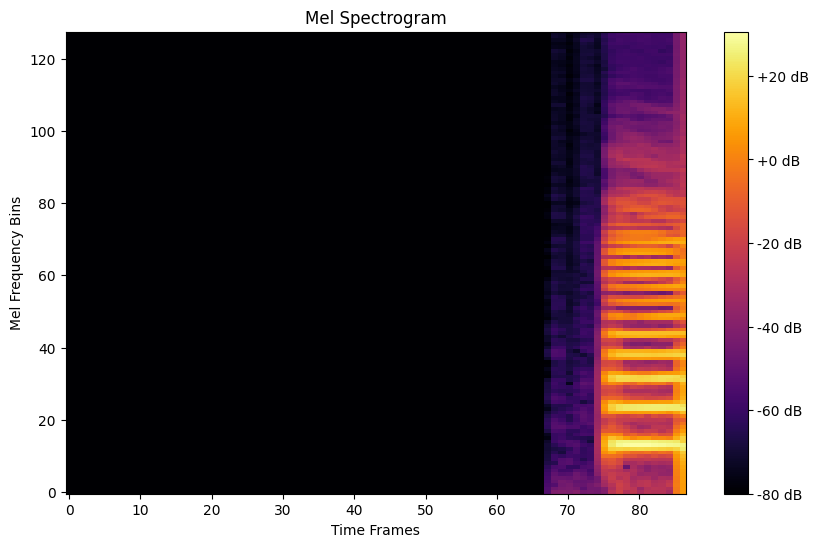

In [194]:
# Load the saved spectrogram
spectrogram = np.load('spectrograms_train/Track00001_mel_spect.npy')

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram[0], aspect='auto', origin='lower', cmap='inferno')  
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bins")
plt.show()